In [14]:
import pandas as pd
import plotly.express as px
import numpy as np
import json
import os
print("Modules imported!")

Modules imported!


In [15]:
def read_json(file_path):
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf8") as file:
            data = json.load(file)
        print(f"Data read from path: {file_path}")
        return data
    else:
        print(f"No data found at path: {file_path}")
        return {}

def serialize_json(filename, data):
    with open(filename, "w", encoding="utf8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
        print(f"Data serialized to path: {filename}")

print("Functions ready!")

Functions ready!


In [16]:
# Data correction: there was a bug in the given framework causing timestamps in data_try_{n}.json to be wrong

# for workerDir in os.scandir('../Data/'):
#     data_try = read_json(workerDir.path + "/data_try_1.json")
#     for workerJson in os.scandir(workerDir.path):
#         if workerJson.name.startswith('quest') or workerJson.name.startswith('doc'):
#             sourceJson = read_json(workerJson.path)
#             if workerJson.name.startswith('quest'):
#                 data_try['timestamps_end'][0][0] = sourceJson['timestamps_end'][0]
#                 data_try['timestamps_elapsed'][0][0] = sourceJson['timestamps_elapsed']
#             else:
#                 workerJson_split = workerJson.name.split('_')
#                 docIndex = int(workerJson_split[1])
#                 docTry = int(workerJson_split[5])
#                 data_try['timestamps_end'][docIndex][docTry - 1] = sourceJson['timestamps_end'][docTry - 1]
#                 data_try['timestamps_elapsed'][docIndex][docTry - 1] = sourceJson['timestamps_elapsed']
#     serialize_json(workerDir.path + "/data_try_1.json", data_try)

In [17]:
# Worker analysis
workerInfoList = []
for workerDir in os.scandir('../Data/'):
    task_data = read_json(workerDir.path + "/task_data.json")
    data_try = read_json(workerDir.path + "/data_try_1.json")
    questionnaire = task_data['questionnaires'][0]['questions']
    reformatQuest = {}
    for question in questionnaire:
        reformatQuest[question['name']] = question['answers']
    device = task_data["worker"]['ngxDeviceDetectorProperties']["device"]
    if device == 'Unknown':
        device = task_data["worker"]['ngxDeviceDetectorProperties']["os"]
    workerInfo = {}
    for key, value in data_try['questionnaires_answers'][0].items():
        workerInfo[key] = reformatQuest[key][int(value)]
    workerInfo['device'] = device
    workerInfoList.append(workerInfo)

df = pd.DataFrame.from_dict(workerInfoList)
df

Data read from path: ../Data/VXCGS/task_data.json
Data read from path: ../Data/VXCGS/data_try_1.json
Data read from path: ../Data/HQWLU/task_data.json
Data read from path: ../Data/HQWLU/data_try_1.json
Data read from path: ../Data/ZLAXX/task_data.json
Data read from path: ../Data/ZLAXX/data_try_1.json
Data read from path: ../Data/KAHOD/task_data.json
Data read from path: ../Data/KAHOD/data_try_1.json
Data read from path: ../Data/JQJWV/task_data.json
Data read from path: ../Data/JQJWV/data_try_1.json
Data read from path: ../Data/ATCOU/task_data.json
Data read from path: ../Data/ATCOU/data_try_1.json
Data read from path: ../Data/HIFZC/task_data.json
Data read from path: ../Data/HIFZC/data_try_1.json
Data read from path: ../Data/VNPSK/task_data.json
Data read from path: ../Data/VNPSK/data_try_1.json
Data read from path: ../Data/KDOFG/task_data.json
Data read from path: ../Data/KDOFG/data_try_1.json
Data read from path: ../Data/EOTDA/task_data.json
Data read from path: ../Data/EOTDA/data_t

,Età,Lavoro,Genere letterario preferito,kindle,Importanza,Quanti libri,device
0,18-25,Studente,Formazione,No,Nulla,1-2,Android
1,18-25,Studente,Giallo,Si,Discreta,6-10,Windows
2,18-25,Studente,Giallo,Si,Discreta,1-2,Android
3,18-25,Studente,Giallo,No,Scarsa,11+,Android
4,18-25,Studente,Fantasy,Si,Discreta,6-10,Android
5,18-25,Studente,Storiografia,No,Discreta,3-5,Android
6,46-55,Dipendente,Storico,Si,Scarsa,1-2,Android
7,46-55,Pensionato,Giallo,No,Scarsa,3-5,Android
8,18-25,Studente,Formazione,Si,Discreta,6-10,iPhone
9,18-25,Studente,Giallo,Si,Discreta,1-2,Mac


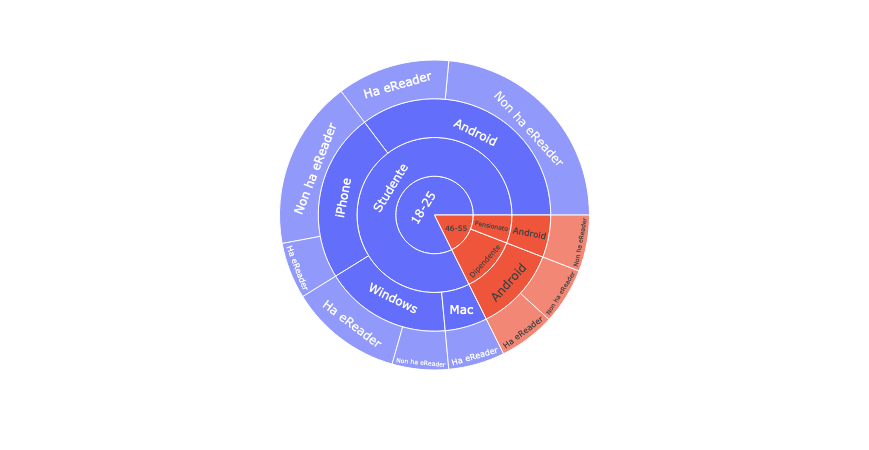

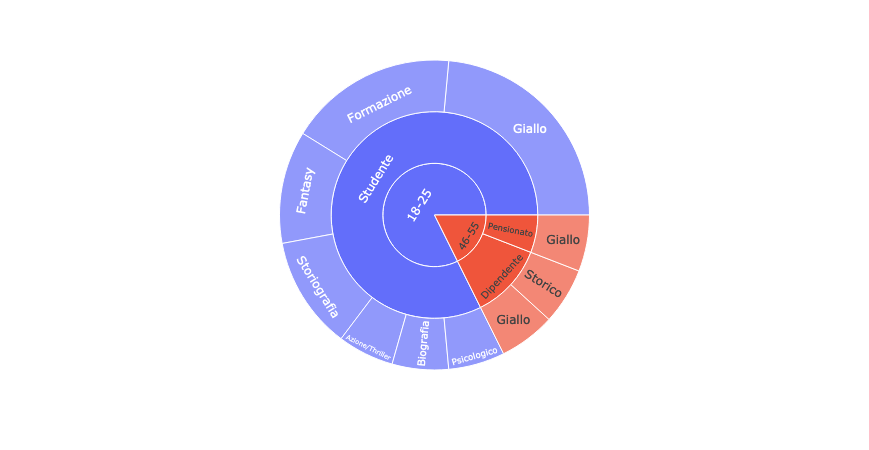

In [18]:
# Apparently this applies changes even to the previous data frame
# Does sunburst_df = df make a copy of the df or what else? 

sunburst_df = df.copy()
sunburst_df["kindle"] = sunburst_df["kindle"].apply({'Si': 'Ha eReader', 'No': 'Non ha eReader'}.get)
fig_device = px.sunburst(sunburst_df, path=['Età', 'Lavoro', 'device', 'kindle'])
fig_device.show()
fig_genere = px.sunburst(sunburst_df, path=['Età', 'Lavoro', 'Genere letterario preferito'])
fig_genere.show()

In [19]:
from collections import Counter

# Count occourences
counter = {key:dict(Counter(df[key])) for key in df}

reformatQuestCount = {}
reformatQuestCountRel = {}

# Absolute frequencies for each option of each parameter
for key, value in reformatQuest.items():
    reformatQuestCount[key] = {label:counter[key].get(label, 0) for label in value}
    
# Relative frequencies for each option of each parameter 
for key, value in reformatQuestCount.items():
    total = sum(value.values())
    if total != 0:
        reformatQuestCountRel[key] = {label:counter[key].get(label, 0)/total for label in value.keys()}
    else:
        reformatQuestCountRel[key] = {label:0 for label in value.keys()}
    

In [24]:
import matplotlib.pyplot as plt

# Building a barplot for the select parameter
def build_barplot(param, rel=None):
    # If rel is selected, the barplot will use relative frequencies
    if not rel:
        plt.bar(reformatQuestCount[param].keys(), reformatQuestCount[param].values())
    else:
        plt.bar(reformatQuestCountRel[param].keys(), reformatQuestCountRel[param].values())

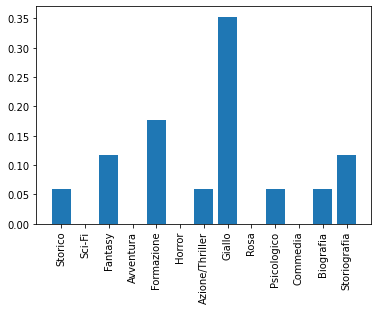

In [26]:
plt.xticks(rotation="vertical")
build_barplot("Genere letterario preferito", rel=True)